In [1]:
import timm
import torch
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
from huggingface_hub import login

In [2]:
login()  # login with your User Access Token, found at https://huggingface.co/settings/tokens

In [3]:
# pretrained=True needed to load UNI2-h weights (and download weights for the first time)
timm_kwargs = {
            'img_size': 224, 
            'patch_size': 14, 
            'depth': 24,
            'num_heads': 24,
            'init_values': 1e-5, 
            'embed_dim': 1536,
            'mlp_ratio': 2.66667*2,
            'num_classes': 0, 
            'no_embed_class': True,
            'mlp_layer': timm.layers.SwiGLUPacked, 
            'act_layer': torch.nn.SiLU, 
            'reg_tokens': 8, 
            'dynamic_img_size': True
        }
model = timm.create_model("hf-hub:MahmoodLab/UNI2-h", pretrained=True, **timm_kwargs)
transform = create_transform(**resolve_data_config(model.pretrained_cfg, model=model))
model.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1536, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1536, out_features=4608, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=1536, out_features=1536, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
      (mlp): GluMlp(
        (fc1): Linear(in_features=1536, out_features=8192, bias=True)
        (act): SiLU()
        (drop1): Dropout(p=0.0, inplace=False)
    

In [5]:
import os
from pathlib import Path
import ipywidgets as widgets
from IPython.display import display
import tifffile
import numpy as np

# Set your source directory path
source_dir = Path(r"K:\499-ProjectData\2025\P25-0048_Thyroid_Recurrence\04-Processed_Datasets\split_cleared_dataset")

def get_tiff_files(directory):
    """Get all TIFF files excluding those ending with _tissue"""
    if not directory.exists():
        print(f"Directory does not exist: {directory}")
        return []
    
    tiff_files = []
    for file in sorted(directory.glob("*.tif*")):
        if not file.stem.endswith("_tissue"):
            tiff_files.append(file.name)
    return tiff_files

def load_volume_and_mask(filename):
    """Load the selected volume and its corresponding tissue mask"""
    if not filename:
        print("No file selected")
        return None, None
    
    volume_path = source_dir / filename
    base_name = Path(filename).stem
    tissue_filename = f"{base_name}_tissue.tif"
    tissue_path = source_dir / tissue_filename
    
    print(f"Loading volume: {volume_path}")
    volume = tifffile.imread(volume_path)
    print(f"Volume shape: {volume.shape}, dtype: {volume.dtype}")
    
    if tissue_path.exists():
        print(f"Loading tissue mask: {tissue_path}")
        tissue_mask = tifffile.imread(tissue_path)
        print(f"Tissue mask shape: {tissue_mask.shape}, dtype: {tissue_mask.dtype}")
    else:
        print(f"Warning: Tissue mask not found at {tissue_path}")
        tissue_mask = None
    
    return volume, tissue_mask

def on_file_selected(change):
    """Callback when file is selected"""
    selected_file = change['new']
    if selected_file:
        volume, tissue_mask = load_volume_and_mask(selected_file)
        global current_volume, current_tissue_mask
        current_volume = volume
        current_tissue_mask = tissue_mask

# Get available TIFF files
tiff_files = get_tiff_files(source_dir)
print(f"Found {len(tiff_files)} TIFF files")

# Create and display dropdown
if tiff_files:
    file_dropdown = widgets.Dropdown(
        options=['Select a file...'] + tiff_files,
        value='Select a file...',
        description='TIFF File:',
        disabled=False,
        style={'description_width': '100px'},
        layout=widgets.Layout(width='500px')
    )
    file_dropdown.observe(on_file_selected, names='value')
    display(file_dropdown)
else:
    print(f"No TIFF files found in: {source_dir}")


Found 212 TIFF files


Dropdown(description='TIFF File:', layout=Layout(width='500px'), options=('Select a file...', '002_B05.20964B.…

In [ ]:
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
import numpy as np

def plot_slice(slice_idx):
    """Plot a single slice from the volume and tissue mask with overlay"""
    if 'current_volume' not in globals() or current_volume is None:
        print("No volume loaded. Please select a file from the dropdown above.")
        return
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot 1: Original volume
    axes[0].imshow(current_volume[slice_idx], cmap='gray')
    axes[0].set_title(f'Volume - Slice {slice_idx}/{current_volume.shape[0]-1}')
    axes[0].axis('off')
    
    # Plot 2: Tissue mask
    if current_tissue_mask is not None:
        axes[1].imshow(current_tissue_mask[slice_idx], cmap='gray')
        axes[1].set_title(f'Tissue Mask - Slice {slice_idx}/{current_tissue_mask.shape[0]-1}')
    else:
        axes[1].text(0.5, 0.5, 'No tissue mask available', 
                    ha='center', va='center', transform=axes[1].transAxes)
        axes[1].set_title('Tissue Mask - Not Available')
    axes[1].axis('off')
    
    # Plot 3: Overlay with grid
    axes[2].imshow(current_volume[slice_idx], cmap='gray')
    
    # Overlay tissue mask with transparency
    if current_tissue_mask is not None:
        mask_overlay = np.ma.masked_where(current_tissue_mask[slice_idx] == 0, current_tissue_mask[slice_idx])
        axes[2].imshow(mask_overlay, cmap='Reds', alpha=0.3)
    
    # Add 224x224 grid
    height, width = current_volume[slice_idx].shape
    
    # Draw vertical lines
    for x in range(0, width, 224):
        axes[2].axvline(x=x, color='cyan', linewidth=1, linestyle='--', alpha=0.7)
    
    # Draw horizontal lines
    for y in range(0, height, 224):
        axes[2].axhline(y=y, color='cyan', linewidth=1, linestyle='--', alpha=0.7)
    
    axes[2].set_title(f'Overlay with 224x224 Grid - Slice {slice_idx}')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Create interactive slider for scrolling through slices
if 'current_volume' in globals() and current_volume is not None:
    depth = current_volume.shape[0]
    interact(plot_slice, 
             slice_idx=IntSlider(min=0, max=depth-1, step=1, value=depth//2, 
                                description='Slice:'))
else:
    print("No volume loaded yet. Please select a file from the dropdown above first.")

interactive(children=(IntSlider(value=52, description='Slice:', max=103), Output()), _dom_classes=('widget-int…

In [8]:
def extract_patches_from_slice(volume_slice, mask_slice, patch_size=224):
    """
    Extract patches from a single slice that contain positive mask pixels.
    
    Returns:
        patches: list of volume patches
        mask_patches: list of mask patches
        positions: list of (slice_idx, y, x) positions
        percentages: list of positive pixel percentages
    """
    height, width = volume_slice.shape
    patches = []
    mask_patches = []
    positions = []
    percentages = []
    
    # Iterate through the image in patch_size steps
    for y in range(0, height - patch_size + 1, patch_size):
        for x in range(0, width - patch_size + 1, patch_size):
            # Extract patches
            volume_patch = volume_slice[y:y+patch_size, x:x+patch_size]
            mask_patch = mask_slice[y:y+patch_size, x:x+patch_size]
            
            # Check if mask has any positive pixels
            positive_pixels = np.sum(mask_patch > 0)
            
            if positive_pixels > 0:
                # Calculate percentage of positive pixels
                total_pixels = patch_size * patch_size
                percentage = (positive_pixels / total_pixels) * 100
                
                patches.append(volume_patch)
                mask_patches.append(mask_patch)
                positions.append((y, x))
                percentages.append(percentage)
    
    return patches, mask_patches, positions, percentages


def extract_patches_from_volume(volume, mask, patch_size=224):
    """
    Extract all patches from the entire 3D volume that contain positive mask pixels.
    
    Returns:
        all_patches: list of volume patches
        all_mask_patches: list of mask patches
        all_positions: list of (slice_idx, y, x) positions
        all_percentages: list of positive pixel percentages
    """
    if volume is None or mask is None:
        print("Volume or mask is None")
        return [], [], [], []
    
    all_patches = []
    all_mask_patches = []
    all_positions = []
    all_percentages = []
    
    num_slices = volume.shape[0]
    
    for slice_idx in range(num_slices):
        patches, mask_patches, positions, percentages = extract_patches_from_slice(
            volume[slice_idx], mask[slice_idx], patch_size
        )
        
        # Add slice index to positions
        positions_3d = [(slice_idx, y, x) for y, x in positions]
        
        all_patches.extend(patches)
        all_mask_patches.extend(mask_patches)
        all_positions.extend(positions_3d)
        all_percentages.extend(percentages)
    
    return all_patches, all_mask_patches, all_positions, all_percentages


# Extract patches from the loaded volume
if 'current_volume' in globals() and current_volume is not None and current_tissue_mask is not None:
    print("Extracting patches...")
    patches, mask_patches, positions, percentages = extract_patches_from_volume(
        current_volume, current_tissue_mask, patch_size=224
    )
    
    print(f"Extracted {len(patches)} patches with positive mask pixels")
    print(f"Percentage range: {min(percentages):.2f}% - {max(percentages):.2f}%")
    print(f"Mean percentage: {np.mean(percentages):.2f}%")
    
    # Store globally for further processing
    global extracted_patches, extracted_mask_patches, patch_positions, patch_percentages
    extracted_patches = patches
    extracted_mask_patches = mask_patches
    patch_positions = positions
    patch_percentages = percentages
else:
    print("Please load a volume and mask first using the dropdown above.")

Extracting patches...
Extracted 3246 patches with positive mask pixels
Percentage range: 0.00% - 99.93%
Mean percentage: 30.91%
Extracted 3246 patches with positive mask pixels
Percentage range: 0.00% - 99.93%
Mean percentage: 30.91%


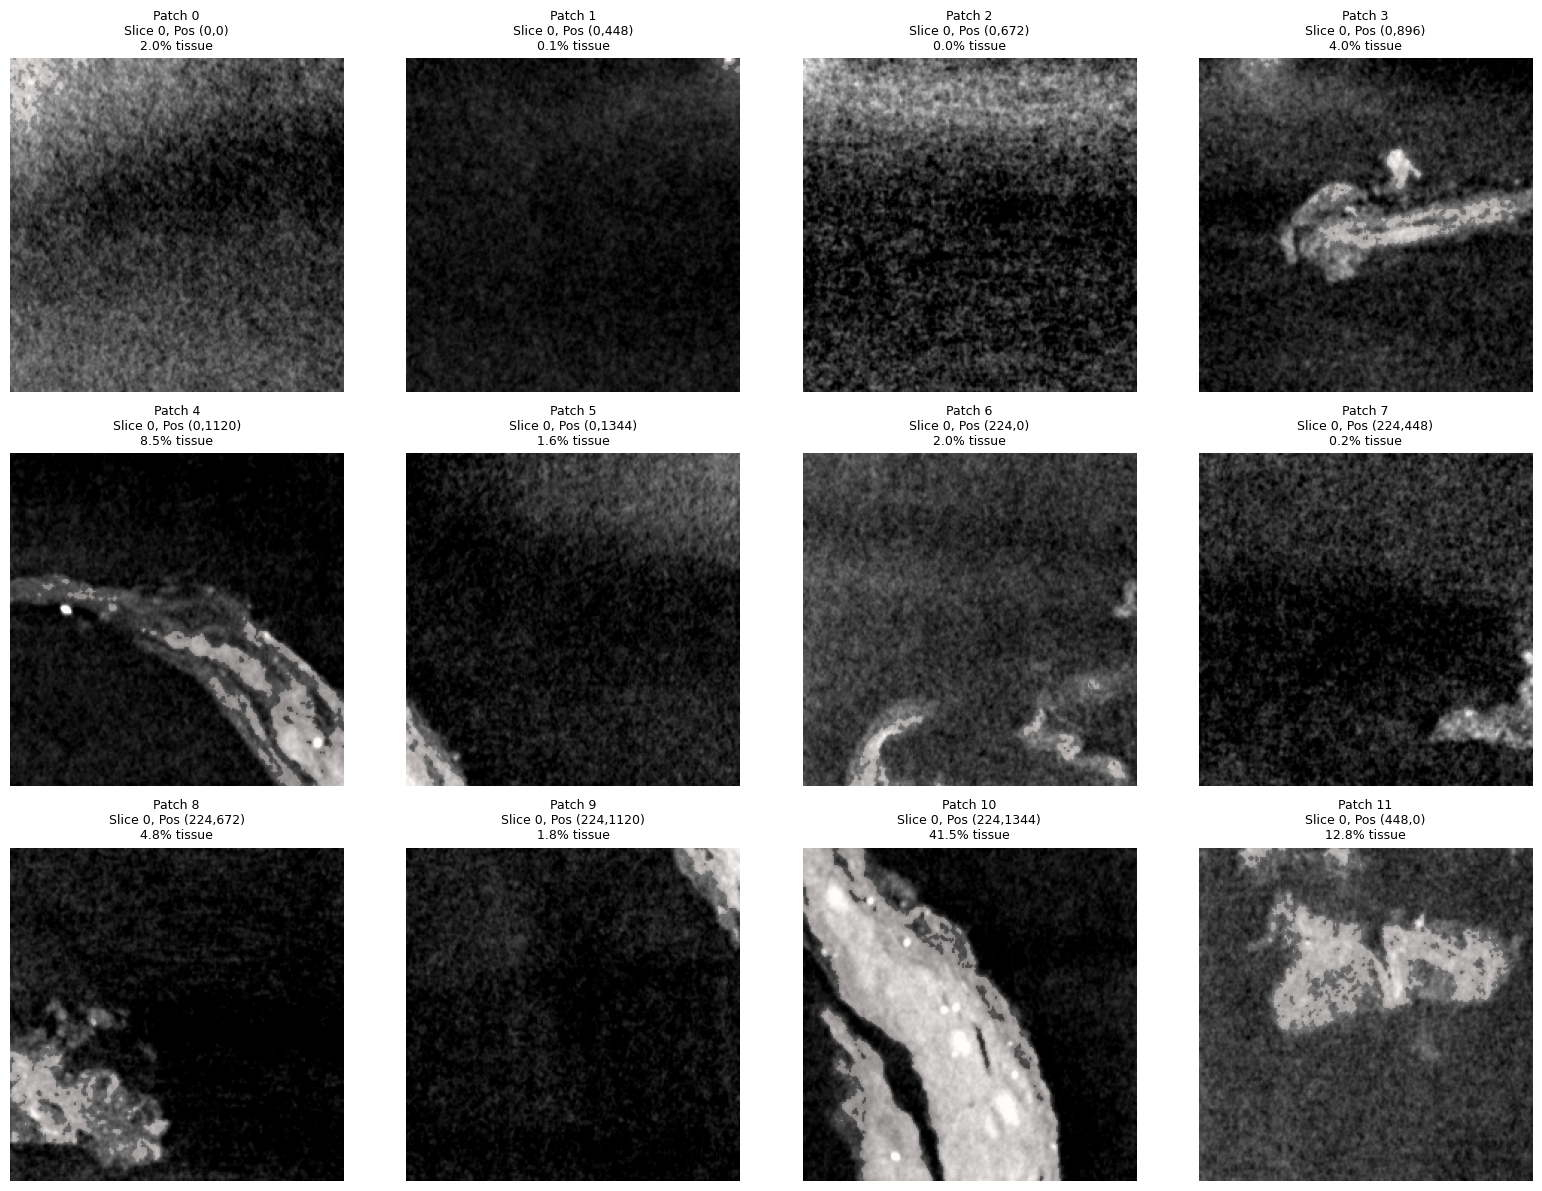


Showing 12 out of 3246 total patches


In [9]:
# Visualize some extracted patches
if 'extracted_patches' in globals() and len(extracted_patches) > 0:
    # Show first 12 patches
    num_to_show = min(12, len(extracted_patches))
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.flatten()
    
    for i in range(num_to_show):
        # Show volume patch with mask overlay
        axes[i].imshow(extracted_patches[i], cmap='gray')
        
        # Overlay mask
        mask_overlay = np.ma.masked_where(extracted_mask_patches[i] == 0, extracted_mask_patches[i])
        axes[i].imshow(mask_overlay, cmap='Reds', alpha=0.3)
        
        slice_idx, y, x = patch_positions[i]
        axes[i].set_title(f'Patch {i}\nSlice {slice_idx}, Pos ({y},{x})\n{patch_percentages[i]:.1f}% tissue', 
                         fontsize=9)
        axes[i].axis('off')
    
    # Hide unused subplots
    for i in range(num_to_show, 12):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nShowing {num_to_show} out of {len(extracted_patches)} total patches")
else:
    print("No patches extracted yet. Run the previous cell first.")

In [10]:
from PIL import Image
from tqdm import tqdm

def grayscale_to_rgb(gray_patch):
    """Convert grayscale patch to RGB by replicating the channel 3 times"""
    # Normalize to 0-255 range if needed
    if gray_patch.max() <= 1.0:
        gray_patch = (gray_patch * 255).astype(np.uint8)
    elif gray_patch.dtype != np.uint8:
        # Scale to 0-255 range
        gray_min, gray_max = gray_patch.min(), gray_patch.max()
        if gray_max > gray_min:
            gray_patch = ((gray_patch - gray_min) / (gray_max - gray_min) * 255).astype(np.uint8)
        else:
            gray_patch = np.zeros_like(gray_patch, dtype=np.uint8)
    
    # Stack grayscale image 3 times to create RGB
    rgb_patch = np.stack([gray_patch, gray_patch, gray_patch], axis=-1)
    return Image.fromarray(rgb_patch)


def extract_embeddings(patches, model, transform, batch_size=16, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Extract embeddings from patches using the UNI model.
    
    Args:
        patches: list of grayscale patches (HxW numpy arrays)
        model: the UNI model
        transform: the transform to apply to images
        batch_size: number of patches to process at once
        device: device to run inference on
    
    Returns:
        embeddings: numpy array of shape (num_patches, embedding_dim)
    """
    model = model.to(device)
    model.eval()
    
    all_embeddings = []
    
    # Process patches in batches
    for i in tqdm(range(0, len(patches), batch_size), desc="Extracting embeddings"):
        batch_patches = patches[i:i+batch_size]
        
        # Convert grayscale to RGB and apply transforms
        batch_tensors = []
        for patch in batch_patches:
            # Convert to RGB (replicate channels)
            rgb_image = grayscale_to_rgb(patch)
            
            # Apply model transforms
            tensor = transform(rgb_image)
            batch_tensors.append(tensor)
        
        # Stack into batch
        batch = torch.stack(batch_tensors).to(device)
        
        # Extract embeddings
        with torch.no_grad():
            embeddings = model(batch)
        
        all_embeddings.append(embeddings.cpu().numpy())
    
    # Concatenate all embeddings
    all_embeddings = np.concatenate(all_embeddings, axis=0)
    return all_embeddings


# Extract embeddings from patches
if 'extracted_patches' in globals() and len(extracted_patches) > 0:
    print(f"Extracting embeddings from {len(extracted_patches)} patches...")
    print(f"Using device: {'cuda' if torch.cuda.is_available() else 'cpu'}")
    
    embeddings = extract_embeddings(
        extracted_patches, 
        model, 
        transform, 
        batch_size=16
    )
    
    print(f"Embeddings shape: {embeddings.shape}")
    print(f"Embedding dimension: {embeddings.shape[1]}")
    
    # Store globally
    global patch_embeddings
    patch_embeddings = embeddings
    
    print("\nEmbedding statistics:")
    print(f"  Mean: {embeddings.mean():.4f}")
    print(f"  Std: {embeddings.std():.4f}")
    print(f"  Min: {embeddings.min():.4f}")
    print(f"  Max: {embeddings.max():.4f}")
else:
    print("No patches extracted yet. Run the patch extraction cell first.")

Extracting embeddings from 3246 patches...
Using device: cpu


Extracting embeddings: 100%|██████████| 203/203 [13:04<00:00,  3.86s/it]

Embeddings shape: (3246, 1536)
Embedding dimension: 1536

Embedding statistics:
  Mean: 0.0029
  Std: 0.4171
  Min: -2.5119
  Max: 2.0176
